## Industrial Machine Fault Detection using Deep Learning
### Machines: Pumps, motors, valves etc. 

### Training a MLP on MFCC features generated from equipment sound files

- Rajesh Siraskar | 22-May-2021
----
- V.2.0: Add predict
- V.2.1: Add seaborn plots with error bands
- V.2.2: Compact version. Move utilities to utilities.py 
----
- Load data
- Split into train/test
- Build MLP network architecture
- Compile network
- Train network

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Custom utilities
from utilities import *

%matplotlib inline

warnings.filterwarnings("ignore")

C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework

In [2]:
JSON_FILE = "audio_files/machine_features.json"
NUMBER_OF_CLASSES = 6 # Machine normal/abnormal
TRAIN_EPOCHS = 200

### Main function
- Network: 
    - 1 input  = Flatten 3-D numpy array and use only 2-Ds (mfcc and hop-length)
    - 3 hidden = 512 x 256 x 64. Activation = ReLU
    - 1 output = Number of classes (genres). 4 genres. Activation = softmax  
- Mini-batch
- Adam optimization
- Learning-rate=0.0001

In [3]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
#     i/p, 3 hidden, o/p and all fully-connected (i.e. dense)
model = keras.Sequential([
    # Input layer: 
    #   input json is a 3D file: We ignore 1st dim and consider only 2nd and 3rd dims
    #   MFCC for each segment, and each mfcc is a vector over an interval = hop-length
    #   - dimension 1: num_segments x n_classes x .wav-files-per-class 
    #   - dimension 2: num_mfcc_vectors_per_segment = math.ceil(samples_per_segment/hop_length)
    #   - dimension 3: num_mfcc
    #   X.shape[1] = dim-2 and X.shape[2]=dim-2
    #   first-dim: interval = inputs.shape[1]
    #   second-dim: mfcc = inputs.shape[2]
    #   NOTE: inputs.shape[0] is the segment number and we are not passing that
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # 1st hidden-layer:
    #   Use ReLU instead of sigmoid. Much faster.
    #   ReLU better convergence. Reduce likelihood of vanishing gradients
    #   Vanishing gradients: Multiply error by derivative of activation fn.
    #   Sigmoid fn. derivative = 0.25. Keep multiplying by 0.25, gradient becomes smaller and smaller
    #   and *vanishes*
    keras.layers.Dense(512, activation="relu"),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu"),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu"),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history = model.fit(X_train, y_train,                 # Training data
                    validation_data=(X_test, y_test), # Test data
                    epochs=TRAIN_EPOCHS,
                    batch_size=32) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 440)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               225792    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 373,958
Trainable params: 373,958
Non-trainable params: 0
________________________________________________________________

Epoch 49/200
4200/4200 [==============================] - 0s 98us/sample - loss: 0.5651 - acc: 0.8795 - val_loss: 0.7962 - val_acc: 0.8428
Epoch 50/200
4200/4200 [==============================] - 0s 99us/sample - loss: 0.4895 - acc: 0.8817 - val_loss: 0.5180 - val_acc: 0.8589
Epoch 51/200
4200/4200 [==============================] - 0s 99us/sample - loss: 0.7563 - acc: 0.8588 - val_loss: 0.4921 - val_acc: 0.8783
Epoch 52/200
4200/4200 [==============================] - 0s 101us/sample - loss: 0.3860 - acc: 0.8971 - val_loss: 0.4821 - val_acc: 0.8711
Epoch 53/200
4200/4200 [==============================] - 0s 97us/sample - loss: 0.6732 - acc: 0.8714 - val_loss: 0.8847 - val_acc: 0.8483
Epoch 54/200
4200/4200 [==============================] - 0s 97us/sample - loss: 0.5285 - acc: 0.8848 - val_loss: 0.6647 - val_acc: 0.8500
Epoch 55/200
4200/4200 [==============================] - 0s 97us/sample - loss: 0.5572 - acc: 0.8779 - val_loss: 0.8944 - val_acc: 0.8061
Epoch 56/200
4200/4200 [==

4200/4200 [==============================] - 0s 95us/sample - loss: 0.1508 - acc: 0.9393 - val_loss: 0.3607 - val_acc: 0.8950
Epoch 108/200
4200/4200 [==============================] - 0s 101us/sample - loss: 0.2034 - acc: 0.9224 - val_loss: 0.6401 - val_acc: 0.8222
Epoch 109/200
4200/4200 [==============================] - 0s 99us/sample - loss: 0.1721 - acc: 0.9345 - val_loss: 0.3115 - val_acc: 0.9050
Epoch 110/200
4200/4200 [==============================] - 0s 99us/sample - loss: 0.1913 - acc: 0.9257 - val_loss: 0.3421 - val_acc: 0.8883
Epoch 111/200
4200/4200 [==============================] - 0s 101us/sample - loss: 0.1511 - acc: 0.9386 - val_loss: 0.2286 - val_acc: 0.9033
Epoch 112/200
4200/4200 [==============================] - 0s 99us/sample - loss: 0.1653 - acc: 0.9321 - val_loss: 0.2660 - val_acc: 0.9111
Epoch 113/200
4200/4200 [==============================] - 0s 99us/sample - loss: 0.1667 - acc: 0.9350 - val_loss: 0.3102 - val_acc: 0.9017
Epoch 114/200
4200/4200 [=======

Epoch 165/200
4200/4200 [==============================] - 0s 103us/sample - loss: 0.1192 - acc: 0.9479 - val_loss: 0.2919 - val_acc: 0.8978
Epoch 166/200
4200/4200 [==============================] - 0s 103us/sample - loss: 0.0999 - acc: 0.9562 - val_loss: 0.2374 - val_acc: 0.9100
Epoch 167/200
4200/4200 [==============================] - 0s 110us/sample - loss: 0.0874 - acc: 0.9579 - val_loss: 0.2178 - val_acc: 0.9211
Epoch 168/200
4200/4200 [==============================] - 0s 101us/sample - loss: 0.1003 - acc: 0.9569 - val_loss: 0.2871 - val_acc: 0.9061
Epoch 169/200
4200/4200 [==============================] - 0s 98us/sample - loss: 0.1079 - acc: 0.9533 - val_loss: 0.2600 - val_acc: 0.9100
Epoch 170/200
4200/4200 [==============================] - 0s 107us/sample - loss: 0.0985 - acc: 0.9567 - val_loss: 0.2169 - val_acc: 0.9167
Epoch 171/200
4200/4200 [==============================] - 0s 107us/sample - loss: 0.0832 - acc: 0.9607 - val_loss: 0.1993 - val_acc: 0.9122
Epoch 172/200


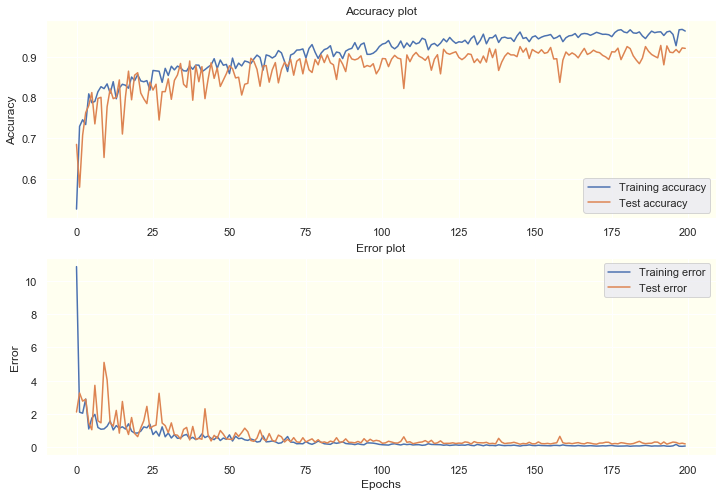

In [4]:
## 6. Plot training curves - NO regularization
plot_history(history, regularization_flag=False)

### Reducing Over-fitting
- 5 techniques
    - Simpler architecture
    - Data-augmentation: Pitch change, Time-stretching, Add noise
    - Early stopping
    - Drop-out
    - Regularization    

- **Drop-out**: NN can't depend on any particular neuron and tries to spread out weights and makes ot robust
- **Regularization**: 
    - Add penalty to error function
    - Punish large weigths
    - L1: Minimize absolute values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|$
    - L2: Minimize _squared_ values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|^2$
    - L1: Robust to outliers, simpler model
    - L2: NOT robust to outliers, learns complex patterns

In [5]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # Hidden-layers: With added Dropout amd Regularization with Lambda=0.001
    # 1st hidden-layer:
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history_reg = model.fit(X_train, y_train,                 # Training data
                        validation_data=(X_test, y_test), # Test data
                        epochs=TRAIN_EPOCHS,
                        batch_size=32)  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 440)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               225792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

4200/4200 [==============================] - ETA: 0s - loss: 1.0176 - acc: 0.774 - 1s 151us/sample - loss: 1.0127 - acc: 0.7755 - val_loss: 0.9046 - val_acc: 0.7956
Epoch 50/200
4200/4200 [==============================] - 1s 148us/sample - loss: 1.0012 - acc: 0.7781 - val_loss: 0.8784 - val_acc: 0.8028
Epoch 51/200
4200/4200 [==============================] - 1s 148us/sample - loss: 0.9999 - acc: 0.7750 - val_loss: 0.8843 - val_acc: 0.8050
Epoch 52/200
4200/4200 [==============================] - 1s 147us/sample - loss: 0.9851 - acc: 0.7786 - val_loss: 0.8621 - val_acc: 0.8022
Epoch 53/200
4200/4200 [==============================] - 1s 143us/sample - loss: 0.9624 - acc: 0.7867 - val_loss: 0.8735 - val_acc: 0.7933
Epoch 54/200
4200/4200 [==============================] - 1s 137us/sample - loss: 0.9679 - acc: 0.7805 - val_loss: 0.8574 - val_acc: 0.8144
Epoch 55/200
4200/4200 [==============================] - 1s 150us/sample - loss: 0.9538 - acc: 0.7852 - val_loss: 0.8543 - val_acc: 0.

4200/4200 [==============================] - 1s 149us/sample - loss: 0.5550 - acc: 0.8252 - val_loss: 0.5161 - val_acc: 0.8333
Epoch 108/200
4200/4200 [==============================] - 1s 148us/sample - loss: 0.5321 - acc: 0.8343 - val_loss: 0.5160 - val_acc: 0.8206
Epoch 109/200
4200/4200 [==============================] - 1s 152us/sample - loss: 0.5216 - acc: 0.8286 - val_loss: 0.5070 - val_acc: 0.8306
Epoch 110/200
4200/4200 [==============================] - 1s 154us/sample - loss: 0.5290 - acc: 0.8252 - val_loss: 0.4909 - val_acc: 0.8394
Epoch 111/200
4200/4200 [==============================] - 1s 147us/sample - loss: 0.5124 - acc: 0.8314 - val_loss: 0.4925 - val_acc: 0.8278
Epoch 112/200
4200/4200 [==============================] - 1s 148us/sample - loss: 0.5058 - acc: 0.8317 - val_loss: 0.5106 - val_acc: 0.8144
Epoch 113/200
4200/4200 [==============================] - 1s 141us/sample - loss: 0.5095 - acc: 0.8226 - val_loss: 0.4968 - val_acc: 0.8233
Epoch 114/200
4200/4200 [==

Epoch 165/200
4200/4200 [==============================] - 1s 134us/sample - loss: 0.4079 - acc: 0.8586 - val_loss: 0.3769 - val_acc: 0.8667
Epoch 166/200
4200/4200 [==============================] - 1s 134us/sample - loss: 0.3980 - acc: 0.8548 - val_loss: 0.3845 - val_acc: 0.8500
Epoch 167/200
4200/4200 [==============================] - 1s 134us/sample - loss: 0.3918 - acc: 0.8583 - val_loss: 0.3761 - val_acc: 0.8556
Epoch 168/200
4200/4200 [==============================] - 1s 133us/sample - loss: 0.3804 - acc: 0.8619 - val_loss: 0.3781 - val_acc: 0.8561
Epoch 169/200
4200/4200 [==============================] - 1s 136us/sample - loss: 0.3831 - acc: 0.8531 - val_loss: 0.3688 - val_acc: 0.8556
Epoch 170/200
4200/4200 [==============================] - 1s 143us/sample - loss: 0.3819 - acc: 0.8540 - val_loss: 0.3765 - val_acc: 0.8617
Epoch 171/200
4200/4200 [==============================] - 1s 145us/sample - loss: 0.3896 - acc: 0.8593 - val_loss: 0.3699 - val_acc: 0.8644
Epoch 172/200

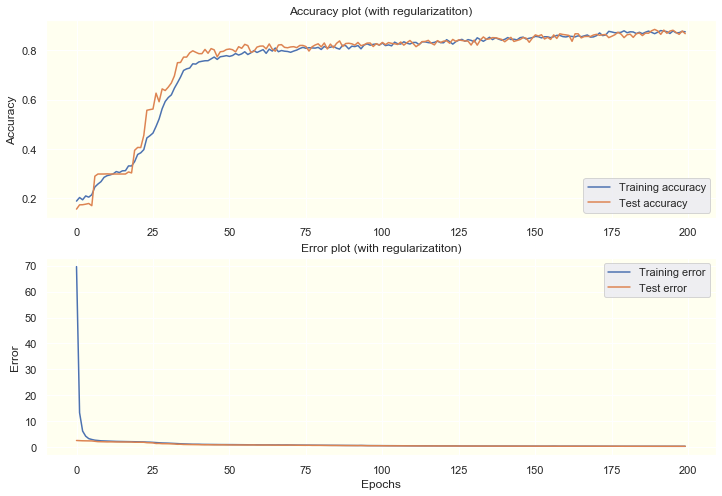

In [6]:
## 6. Plot training curves - With drop-out and L2 regularization
plot_history(history_reg, regularization_flag=True)

In [7]:
import random

# First get the labels from the numerical indices, so that predicted vales are readable
signal_label_mappings = map_signal_labels(JSON_FILE)

## 6. Predict
for n in range(20):
    sample = random.randint(0,19) # Total 20 samples, so select any sample 1-20
    X = X_test[sample] 
    y = y_test[sample]

    predict(model, X, y, signal_label_mappings)

Expected machine signal: 'slide_rail_normal' 	|  Predicted: 'slide_rail_normal'
Expected machine signal: 'industrial_fan_abnormal' 	|  Predicted: 'industrial_fan_abnormal'
Expected machine signal: 'slide_rail_normal' 	|  Predicted: 'slide_rail_normal'
Expected machine signal: 'slide_rail_normal' 	|  Predicted: 'slide_rail_normal'
Expected machine signal: 'valve_abnormal' 	|  Predicted: 'valve_abnormal'
Expected machine signal: 'valve_normal' 	|  Predicted: 'valve_normal'
Expected machine signal: 'industrial_fan_abnormal' 	|  Predicted: 'industrial_fan_abnormal'
Expected machine signal: 'industrial_fan_normal' 	|  Predicted: 'industrial_fan_normal'
Expected machine signal: 'valve_normal' 	|  Predicted: 'valve_normal'
Expected machine signal: 'industrial_fan_normal' 	|  Predicted: 'industrial_fan_normal'
Expected machine signal: 'industrial_fan_abnormal' 	|  Predicted: 'industrial_fan_abnormal'
Expected machine signal: 'industrial_fan_normal' 	|  Predicted: 'industrial_fan_normal'
Expect